In [2]:
import pystan
import numpy as np
import arviz as ar

def bym_model():
    """Generates BYM2 Model with example data within parameters and includes the ICAR component"""
    # Actual Stan code block for BYM2 Model
    bym_code = """

    functions {
        real icar_normal_lpdf(vector phi, int N, int[] node1, int[] node2){
            return -0.5 * dot_self(phi[node1] - phi[node2]) + normal_lpdf(sum(phi) | 0, 0.001 * N);
        }
    }

    data {
    int<lower=0> N;
    int<lower=0> edges;
    int<lower=1, upper=N> node1[edges];
    int<lower=1, upper=N> node2[edges];
    int<lower=0> y[N];
    vector<lower=0>[N] E;
    int<lower=1> K;
    matrix[N, K] x;
    real<lower=0> scaling_factor;
    }

    transformed data {
        vector[N] log_E = log(E);
    }

    parameters {
        real beta0;
        vector[K] betas;
        real logit_rho;
        vector[N] phi;
        vector[N] theta;
        real<lower=0> sigma;
    }

    transformed parameters {
        real<lower=0, upper=1> rho = inv_logit(logit_rho);
        vector[N] convolved_re = sqrt(rho / scaling_factor) * phi + sqrt(1 - rho) * theta;
    }

    model {
        y ~ poisson_log(log_E + beta0 + x * betas + convolved_re * sigma);
        beta0 ~ normal(0, 1);
        betas ~ normal(0, 1);
        logit_rho ~ normal(0, 1);
        sigma ~ normal(0, 1);
        theta ~ normal(0, 1);
        phi ~ icar_normal_lpdf(N, node1, node2);
    }

    generated quantities {
        vector[N] eta = log_E + beta0 + x * betas + convolved_re * sigma;
        vector[N] mu = exp(eta);
        int y_rep[N];
        if (max(eta) > 20) {
            //avoid overflow in poisson_log
            print("max eta is too large: ", max(eta));
        for (n in 1:N)
           y_rep[n] = -1;
    } else {
        for (n in 1:N)
            y_rep[n] = poisson_log_rng(eta[n]);
        }
    }
    """

    # intialized matrix and data
    matrix = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
    print(matrix.shape)
    bym_data = {
        'N': 5,
        'edges': 10,
        'node1': [1, 1, 2, 2, 2, 3, 4, 5, 2, 3],
        'node2': [2, 1, 1, 1, 2, 3, 4, 5, 5, 2],
        'y': [1, 2, 3, 4, 5],
        'E': [1, 1, 2, 3, 4],
        'K': 4,
        'x': matrix,
        'scaling_factor': 2.0
    }
    # Utitlize pystan package to allow the built-in StanModel class to fully generate a model and arviz to plot
    sm = pystan.StanModel(model_code=bym_code)
    fit = sm.sampling(data=bym_data, iter=1000, chains=4)
    ar.plot_density(fit, var_names=['beta0', 'betas', 'logit_rho', 'sigma', 'theta'])



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_facc8ab0a2ebc9a77c5168189439d5c8 NOW.


(5, 4)


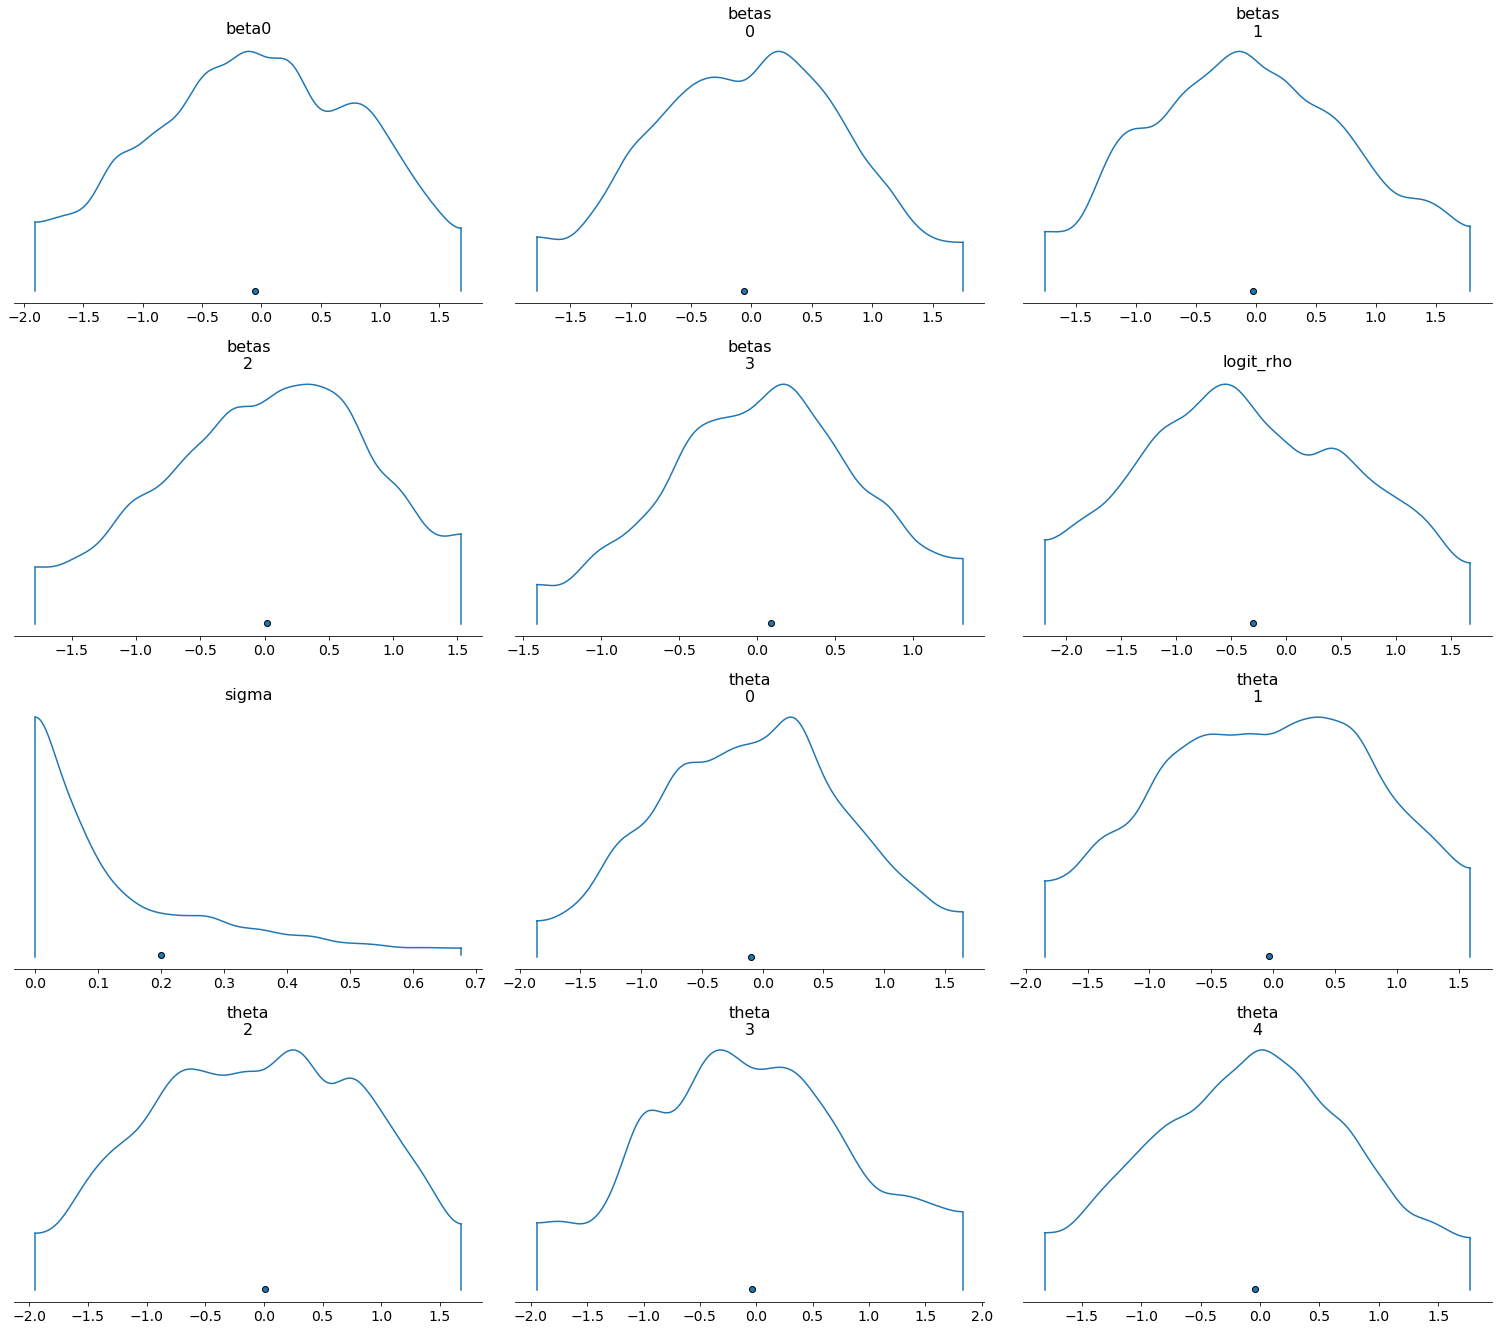

In [3]:
bym_model()